In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!cp -r /content/drive/MyDrive/train_dataset /content/
!cp -r /content/drive/MyDrive/test_dataset /content/


In [3]:
import os

In [4]:
def count_images_in_split(folder):
    print(f"\nFolder: {folder}")
    classes = [d for d in os.listdir(folder) if os.path.isdir(os.path.join(folder, d))]
    print(f"Classes: {classes}")

    total_images = 0
    for class_name in classes:
        class_path = os.path.join(folder, class_name)
        # Count only files (images)
        num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        total_images += num_images
        print(f"Class: {class_name} - Number of Images: {num_images}")

    print(f"Total images in {folder}: {total_images}")

# Verify the number of images in each split
print("Training Set:")
count_images_in_split('train_dataset')

print("\nTest Set:")
count_images_in_split('test_dataset')

Training Set:

Folder: train_dataset
Classes: ['trash', 'paper', 'metal', 'plastic', 'glass', 'cardboard']
Class: trash - Number of Images: 109
Class: paper - Number of Images: 475
Class: metal - Number of Images: 328
Class: plastic - Number of Images: 385
Class: glass - Number of Images: 400
Class: cardboard - Number of Images: 322
Total images in train_dataset: 2019

Test Set:

Folder: test_dataset
Classes: ['trash', 'paper', 'metal', 'plastic', 'glass', 'cardboard']
Class: trash - Number of Images: 28
Class: paper - Number of Images: 119
Class: metal - Number of Images: 82
Class: plastic - Number of Images: 97
Class: glass - Number of Images: 101
Class: cardboard - Number of Images: 81
Total images in test_dataset: 508


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to the training and test datasets
train_dir = "train_dataset/"
test_dir = "test_dataset/"

# Define image dimensions
img_height = 512
img_width = 384
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/Test Data Generator (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2019 images belonging to 6 classes.
Found 508 images belonging to 6 classes.


In [6]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# InceptionV3
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

x = base_model_inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions_inception = Dense(6, activation='softmax')(x)

model_inception = Model(inputs=base_model_inception.input, outputs=predictions_inception)

for layer in base_model_inception.layers:
    layer.trainable = False

model_inception.compile(optimizer=Adam(),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

history_inception = model_inception.fit(train_generator,
                                        epochs=50,
                                        validation_data=validation_generator)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.5550 - loss: 1.3090 - val_accuracy: 0.7579 - val_loss: 0.6386
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.7528 - loss: 0.6793 - val_accuracy: 0.8346 - val_loss: 0.4882
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8214 - loss: 0.4862 - val_accuracy: 0.8071 - val_loss: 0.5134
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8286 - loss: 0.4720 - val_accuracy: 0.8307 - val_loss: 0.4568
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8598 - loss: 0.4089 - val_accuracy: 0.8406 - val_loss: 0.4167
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.8842 - loss: 0.3279 - val_accuracy: 0.8563 - val_loss: 0.4209
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8853 - loss: 0.3553 - val_accuracy: 0.8445 - val_loss: 0.4830
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.8672 - loss: 0.3621 - val_accuracy: 0.8287 - val_lo

In [7]:
# Define paths to the test dataset directory
test_dir = "test_dataset/"

# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Evaluate the model on the test data
test_loss, test_accuracy = model_inception.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Found 508 images belonging to 6 classes.
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 238ms/step - accuracy: 0.8750 - loss: 0.4163
Test loss: 0.4749441146850586
Test accuracy: 0.8700787425041199


In [8]:
model_inception.save("garbage_classification_model_inception.h5")

In [10]:
import matplotlib.pyplot as plt


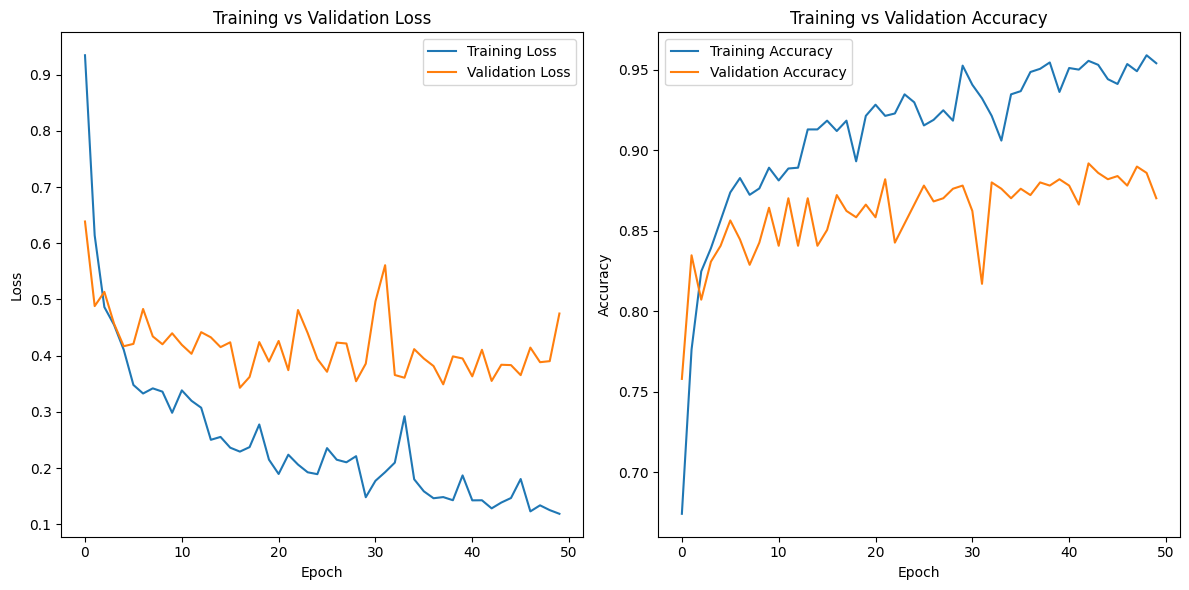

In [11]:
# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_inception.history['loss'], label='Training Loss')
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training vs validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image as keras_image

def predict_waste_category(image_path, model):
    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((384, 512))  # Resize the image to match the input shape of the model
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict the category of waste
    prediction = model.predict(img_array)
    waste_categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
    predicted_category_index = np.argmax(prediction)
    predicted_category = waste_categories[predicted_category_index]

    # Get the probability associated with the predicted category
    probability = prediction[0][predicted_category_index]
    return predicted_category, probability


In [36]:
# Example usage
image_path = "/content/rod2.webp"
predicted_category, probability = predict_waste_category(image_path, model_inception)
print("Predicted waste category:", predicted_category)
print("Probabilty:",probability)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Predicted waste category: glass
Probabilty: 0.52346975
